# Building the UI
## Before we start (OPTIONAL)
Before we start, it might be a good idea to fork this repository. This is to ensure that we can easily get a link to your schema.

![fork](./img/fork.png)

Once you forked the repo, you can then clone your own repository.

## Introduction
In addition to the Neo4j console and the notebook earlier, we can provide develop a public facing website that we can share with the public without providing them write access to the neo4j database.

The UI provides single and two-term search where the latter uses allShortestPath to query all the shortest paths between two terms. To build the UI, we need to create a UI schema that is built using the data that was ingested in the graph db. This notebook automates the creation of this schema file.

In [1]:
import re
import json
from glob import glob
import pandas as pd

## Node Schema

```
{
    "node": "Gene",
    "example": [
        "COPB2",
        "SDF2L1"
    ],
    "display": [
        {
            "label": "Gene ID",
            "text": "${id}",
            "type": "text"
        },
        {
            "label": "label",
            "text": "${label}",
            "type": "text"
        },
        {
            "label": "uri",
            "text": "${uri}",
            "href": "${uri}",
            "type": "link"
        }
    ],
    "search": [
        "id",
        "label"
    ],
    "color": "#c5e1a5"
}

```
This is a node schema for the node "Gene". The example field will be displayed display as an example on the UI while the display field tells the UI what to display as a tooltip. Meanwhile, search tells the UI that we can search both id and label fields of the nodes. Node colors are automatically generated but can otherwise be set using the field color for more customization.

In [2]:
node_schema = []
node_pattern = "(?P<directory>.+)/(?P<label>.+)\.(?P<entity>.+)\.csv"

# Change this path to the file including all of your serialized edges and nodes
for filename in glob("/Users/nialingam/Desktop/all_csv/*.nodes.csv"):
    match = re.match(node_pattern, filename).groupdict()
    label = match["label"].replace("_", " ")
    df = pd.read_csv(filename)
    display = []
    for i in df.columns:
        if i == "id":
            display.append({
                'label': '%s ID'%label,
                'text': "${%s'}"%i,
                'type': 'text'
            })
        else:
            val = str(df.at[0, i])
            if val.startswith("http"):
                display.append({
                    'label': i,
                    'text': "${%s}"%i,
                    'href': "${%s}"%i,
                    'type': 'link'
                })
            else:
                display.append({
                    'label': i,
                    'text': "${%s}"%i,
                    'type': 'text'
                })
    examples = list(df.head(2).label)
    node = {
        "node": label,
        "example": examples,
        "display": display,
        "relation": [],
        "search": [
            "id",
            "label",
        ],
        # "color": "#c5e1a5"
    }
    node_schema.append(node)
        

<>:2: SyntaxWarning: invalid escape sequence '\.'
<>:2: SyntaxWarning: invalid escape sequence '\.'
/var/folders/xb/bmqyy0q9303b04mkwvb2k48m0000gn/T/ipykernel_8765/1831667586.py:2: SyntaxWarning: invalid escape sequence '\.'
  node_pattern = "(?P<directory>.+)/(?P<label>.+)\.(?P<entity>.+)\.csv"


In [3]:
len(node_schema)

126

## Edge Schema
```
{
    "match": [
        "KEGG"
    ],
    "selected": true,
    "display": [
        {
            "label": "source",
            "text": "${source}",
            "type": "text"
        },
        {
            "label": "relation",
            "text": "${relation}",
            "type": "text"
        },
        {
            "label": "target",
            "text": "${target}",
            "type": "text"
        },
        {
            "label": "source label",
            "text": "${source_label}",
            "type": "text"
        },
        {
            "label": "target label",
            "text": "${target_label}",
            "type": "text"
        },
        {
            "label": "resource",
            "text": "${resource}",
            "href": "${resource}",
            "type": "link"
        }
    ]
}
```

This is the same with node schema with a few differences, first match allows you to match multiple edge types and selected is a field that allows us to select what edges are queried by default when doing two term searches.

In [4]:
edge_schema = []
edge_pattern = "(?P<directory>.+)/(?P<source_type>.+)\.(?P<relation>.+)\.(?P<target_type>.+)\.(?P<entity>.+)\.csv"

# change path name to the same folder as above!
for filename in glob("/Users/nialingam/Desktop/all_csv/*.edges.csv"):
   match = re.match(edge_pattern, filename).groupdict()
   entity = match["entity"]
   source_type = match["source_type"]
   relation = match["relation"]
   edge = {
      "match": [relation],
      "selected": True,
   }
   df = pd.read_csv(filename)
   display = []
   for i in df.columns:
      if i == "id":
         display.append({
               'label': '%s ID'%label,
               'text': "${%s}"%i,
               'type': 'text'
         })
      else:
         val = str(df.at[0, i])
         if val.startswith("http"):
               display.append({
                  'label': i.replace("_", " "),
                  'text': "${%s}"%i,
                  'href': "${%s}"%i,
                  'type': 'link'
               })
         else:
               display.append({
                  'label': i.replace("_", " "),
                  'text': "${%s}"%i,
                  'type': 'text'
               })
         edge["display"] = display
   edge_schema.append(edge)
         

<>:2: SyntaxWarning: invalid escape sequence '\.'
<>:2: SyntaxWarning: invalid escape sequence '\.'
/var/folders/xb/bmqyy0q9303b04mkwvb2k48m0000gn/T/ipykernel_8765/3852481074.py:2: SyntaxWarning: invalid escape sequence '\.'
  edge_pattern = "(?P<directory>.+)/(?P<source_type>.+)\.(?P<relation>.+)\.(?P<target_type>.+)\.(?P<entity>.+)\.csv"


In [5]:
len(edge_schema)

171

## Additional schema

The next part are miscellaneous schemas that you can use to modify our UI. Notice the tabs field, this is where we define the pages in our knowledge graph as well as the components that you want to render.

Currently we have the following components available:
1. KnowledgeGraph: this renders the single and two term search components
2. Markdown: this is for rendering static markdown files, useful for tutorials
3. Enrichment: For enrichment page.
   
Each component takes specific props like init_function that initializes/prefetch the static props for the page. For this example, we only look at the KnowledgeGraph component. For more information on how to use the other components you can check: https://maayanlab.cloud/enrichr-kg/api/knowledge_graph/schema

In [6]:
# First you need to modify this based on your dataset. 
# This will be the initial query that the users will see when visiting your site
initial_query = {
	"start": "gene",
	"start_term": "STAT3",
	"start_field": "label"
}

In [7]:
# This creates the schema.json file that will store your schema!

# Change the titles and icons to your KG
title = "Harmonizome-KG"
icon = "https://minio.dev.maayanlab.cloud/enrichr-kg/enrichr-kg.png"
rest = {
    "header": {
		"header": title,
		"title": title,
		"background": {
			"backgroundColor": "#000",
			"contrastText": "#FFF"
		},
		"icon": {
			"src": icon,
			"favicon": icon,
			"faviconTitle": title,
			"alt": title,
			"key": "%s_logo"%title,
			"width": 100,
			"height": 60
		},
		"tabs": [
			{
				"endpoint": "/",
				"label": "Term & Gene Search",
				"type": "page",
				"component": "KnowledgeGraph",
				"props": {
					"init_function": "initialize_kg",
					"initial_query": initial_query,
					"subheader": {
						"url_field": "filter",
						"query_field": "relation"
					}
				}
				}
		]
	},
	"footer": {
		"style": {
            "background": "#000",
            "color": "#FFF"
        },
		"layout": [
			[
				{
                    "component": "logo",
                    "props": {
                        "src": "https://minio.dev.maayanlab.cloud/enrichr-kg/enrichr-kg.png",
                        "alt": "enrichr-kg",
                        "title": "Enrichr-KG",
                        "color": "inherit",
                        "size": "small"
                    }
                },
				{
                    "component": "github",
                    "props": {
                        "code": "https://github.com/MaayanLab/enrichr-kg",
                        "issues": "https://github.com/MaayanLab/enrichr-kg-issues/issues/new"
                    }
                }
			],
			[
				{
					"component": "icon",
					"props": {
						"type": "icon",
						"key": "lab_icon",
						"src": "https://minio.dev.maayanlab.cloud/enrichr-kg/maayanlab.png",
						"alt": "MaayanLab",
						"href": "https://labs.icahn.mssm.edu/maayanlab/",
						"height": 60,
						"width": 150
					}
				  }
			],
			[
				{
					"component": "icon",
					"props": {
						"type": "icon",
						"key": "center_icon",
						"src": "https://minio.dev.maayanlab.cloud/enrichr-kg/bioinformatics.png",
						"alt": "COB",
						"href": "https://icahn.mssm.edu/research/bioinformatics",
						"height": 60,
						"width": 150
					}
				  }
			]
		],
		"footer_text": "<span style='color:white'>Please acknowledge Enrichr-KG in your publications by citing the following reference:<br><a style='color: cyan' href='https://doi.org/10.1093/nar/gkad393'>Evangelista JE, Xie Z, Marino GB, Nguyen N, Clarke DJB, Ma'ayan A. Enrichr-KG: bridging enrichment analysis across multiple libraries. Nucleic Acids Res. 2023 May 11:gkad393. doi: 10.1093/nar/gkad393. PMID: 37166973.</a></span>"
	},
	"ui_theme": "enrichr_kg_theme"
}

## Putting it all together

In [8]:
schema = {
    "nodes": node_schema,
    "edges": edge_schema,
    **rest
}

with open("../schema_sample.json", 'w') as o:
    o.write(json.dumps(schema, indent=4))

Once you have the schema you can upload it somewhere to obtain a link of the file. If you forked the repo you can commit it and push to your forked repository.

```
git add schema.json
git commit -m updated schema
git push
```

To get the link, go to schema.json on github and click raw:

![raw](./img/raw.png)
![raw_link](./img/raw_link.png)

Now let's clone the knowledge graph UI

```
git clone git@github.com:MaayanLab/Gene-Knowledge-Graph.git
cd Gene-Knowledge-Graph 
git checkout next14
```

Now let's go and copy `.env.example`

```
cp .env.example .env
```

.env should look something like this

```
NEXT_PUBLIC_PREFIX=
NEXT_PUBLIC_NEO4J_DEV_URL=bolt://neo4j:7687
NEXT_PUBLIC_NEO4J_URL=bolt://neo4j:7687

NEXT_PUBLIC_NEO4J_USER=neo4j
NEXT_PUBLIC_NEO4J_NAME=kg

NEXT_PUBLIC_NEO4J_USER=neo4j
NEXT_PUBLIC_NEO4J_NAME=kg

NEXT_PUBLIC_NEO4J_PASSWORD=pass


NEXT_PUBLIC_DOMAINS=minio.dokku.maayanlab.cloud,github.com,minio.dev.maayanlab.cloud,s3.amazonaws.com,raw.githubusercontent.com
NEXT_PUBLIC_ENRICHR_URL=https://maayanlab.cloud/Enrichr
NEXT_PUBLIC_GENESHOT_URL=https://maayanlab.cloud/geneshot
NEXT_PUBLIC_HOST=http://localhost:3000
NEXT_PUBLIC_SCHEMA=https://raw.githubusercontent.com/MaayanLab/KnowledgeGraphDemo/main/schema.json
NEXT_PUBLIC_TURL=turlkey
NEXT_PUBLIC_TURL_URL=https://maayanlab.cloud/turl/api/register
APP_NAME=kg-demo
DOCKERHUB_NAME=maayanlab
```

Now go ahead and change `NEXT_PUBLIC_SCHEMA` to your link, you can also change `APP_NAME` and `DOCKERHUB_NAME` according to your dockerhub account

Run the following:
```
cd cli
python version-compose.py
cd ..
```
This adjusts your compose file based on your .env

## Ingestion
Now let's try ingesting data. Runa the following script

```
docker-compose up neo4j
# this is usually python ../src/import_csv.py ../notebooks/csv 
python /path/to/import_csv.py /path/to/csv
```
![ingestion](img/ingestion.png)


## Running it locally

You might need to install Node.js and NPM first https://docs.npmjs.com/downloading-and-installing-node-js-and-npm
```
npm i
npm run dev
```
go to http://localhost:3000


## Building and Running Docker Container

```
docker-compose build kg
docker-compose up
```
you can check http://localhost:3000 again

```
# push to dockerhub
docker-compose push kg
```

## Add colors

In [7]:
import glasbey
import json
import seaborn as sns

In [3]:
with open('../schema.json') as o:
	schema = json.loads(o.read())

In [4]:
len(schema["nodes"])

125

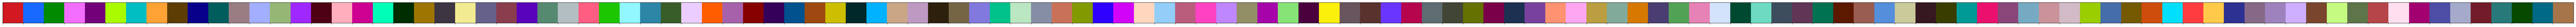

In [8]:
palette = glasbey.create_palette(palette_size=len(schema["nodes"]))
sns.palplot(palette)

In [9]:
palette[0]

'#d21820'

In [10]:
index = 0
for i in schema["nodes"]:
	i["color"] = palette[index]
	index += 1

In [14]:
with open("../schema.json", "w") as o:
	o.write(json.dumps(schema, indent=4))